Import libraries and dataset

In [ ]:
import numpy as np
import pandas as pd
import re
import string
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

train = pd.read_csv('../input/train-data/train.csv')

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
train = train.dropna()
# test = test.dropna()

num_of_rows = int(len(train) * 0.9)
values = train.values
np.random.shuffle(values)
train = values[:num_of_rows] #indexes rows for training data
validation = values[num_of_rows:] #indexes rows for test data

train = pd.DataFrame(train,columns=['text','source','label'])
validation = pd.DataFrame(validation,columns=['text','source','label'])

train = train.drop('source',axis=1)
validation = validation.drop('source',axis=1)

print(train.shape,validation.shape)

(2069, 2) (230, 2)


Divide dataset in train and validation

Definition of Parameters

In [ ]:
max_len = None # Max lenght of the text for input
batch_size = 4
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Functions and classes

In [ ]:
# Dataset creator for Pytorch
class DatasetCreator(Dataset):
    def __init__(self, processed_data, train):
        self.data = processed_data
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        line = self.data.iloc[index]
        if self.train:
            return {'text': line['text'], 'label': line['label']}
        else:
            return {'text': line['text'], 'label': 0}

# Class to tokenize and process the text for input to the dataloader
class GPT2_collator(object):
    def __init__(self, tokenizer, max_seq_len=None):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        return

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [int(sequence['label']) for sequence in sequences]
        inputs = self.tokenizer(text=texts,
                                return_tensors='pt',
                                padding=True,
                                truncation=True,
                                max_length=self.max_seq_len)
        inputs.update({'labels': torch.tensor(labels)})
        return inputs


# Function for training
def epoch_train(dataloader, optimizer, scheduler, device):
    global model
    model.train()
    predictions_labels = []
    true_labels = []
    total_loss = 0

    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    avg_epoch_loss = total_loss / len(dataloader)
    return predictions_labels, true_labels, avg_epoch_loss

# Function for validation
def epoch_validate(dataloader, device):
    global model
    model.eval()
    predictions_labels = []
    true_labels = []
    total_loss = 0

    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            total_loss += loss.item()
            predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    avg_epoch_loss = total_loss / len(dataloader)
    return predictions_labels, true_labels, avg_epoch_loss

def epoch_predict(dataloader, device):
    global model
    model.eval()
    predictions_labels = []

    for batch in tqdm(dataloader, total=len(dataloader)):
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            _, logits = outputs[:2]
            predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    return predictions_labels

Load Model and Tokenizer

In [ ]:
print('Loading gpt-2 model')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path='gpt2', num_labels=2)

print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path='gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path='gpt2', config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)

Loading gpt-2 model


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loading tokenizer...


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Loading model...


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid

Prepare dataloader

In [ ]:
gpt2_collator = GPT2_collator(tokenizer=tokenizer, max_seq_len=max_len)

# Prepare training data
train_data = DatasetCreator(train, train=True)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=gpt2_collator)

# Prepare validation data
val_data = DatasetCreator(validation, train=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=gpt2_collator)

Train and validate model

In [ ]:
optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-8, weight_decay=0.01)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
loss = []
accuracy = []
val_loss_list = []
val_accuracy_list = []

for epoch in tqdm(range(epochs)):
    train_labels, true_labels, train_loss = epoch_train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(true_labels, train_labels)
    print('epoch: %.2f train accuracy %.2f' % (epoch, train_acc))
    loss.append(train_loss)
    accuracy.append(train_acc)

    val_labels, val_true_labels, val_loss = epoch_validate(val_dataloader, device)
    val_acc= accuracy_score(val_true_labels, val_labels)
    print('epoch: %.2f validation accuracy %.2f' % (epoch, val_acc))
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_acc)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

epoch: 0.00 train accuracy 0.80


  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 0.00 validation accuracy 0.85


  0%|          | 0/518 [00:00<?, ?it/s]

epoch: 1.00 train accuracy 0.86


  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 1.00 validation accuracy 0.93


  0%|          | 0/518 [00:00<?, ?it/s]

epoch: 2.00 train accuracy 0.90


  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 2.00 validation accuracy 0.91


  0%|          | 0/518 [00:00<?, ?it/s]

epoch: 3.00 train accuracy 0.89


  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 3.00 validation accuracy 0.94


  0%|          | 0/518 [00:00<?, ?it/s]

epoch: 4.00 train accuracy 0.89


  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 4.00 validation accuracy 0.92


  0%|          | 0/518 [00:00<?, ?it/s]

epoch: 5.00 train accuracy 0.90


  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 5.00 validation accuracy 0.95


  0%|          | 0/518 [00:00<?, ?it/s]

epoch: 6.00 train accuracy 0.90


  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 6.00 validation accuracy 0.94


  0%|          | 0/518 [00:00<?, ?it/s]

epoch: 7.00 train accuracy 0.91


  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 7.00 validation accuracy 0.93


  0%|          | 0/518 [00:00<?, ?it/s]

epoch: 8.00 train accuracy 0.91


  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 8.00 validation accuracy 0.93


  0%|          | 0/518 [00:00<?, ?it/s]

epoch: 9.00 train accuracy 0.91


  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 9.00 validation accuracy 0.94


Plot approximate loss and accuracy

In [ ]:
# Print train and validation loss
fig_loss = go.Figure()

fig_loss.add_trace(go.Scatter(x=[*range(0,len(loss),1)], y=loss,
                              mode='lines',
                              name='train_loss'))
fig_loss.add_trace(go.Scatter(x=[*range(0,len(loss),1)], y=val_loss_list,
                              mode='lines',
                              name='validation loss'))

# Print train and validation accuracy
fig_acc = go.Figure()

fig_acc.add_trace(go.Scatter(x=[*range(0,len(accuracy),1)], y=accuracy,
                              mode='lines',
                              name='train accuracy'))
fig_acc.add_trace(go.Scatter(x=[*range(0,len(accuracy),1)], y=val_accuracy_list,
                              mode='lines',
                              name='validation accuracy'))

fig_loss.show()
fig_acc.show()

Prepare Evaluation

In [ ]:
test = pd.read_csv("../input/test-data/test.csv")
test.head()

,news,source,label
0,ನಿರಂತರ ಮಳೆ: ಕೊಳೆತ ಉದ್ದು ಬೆಳೆ ...,prajavani,1
1,ಸಲಿಂಗ ಸಂಬಂಧ ವಿರೋಧಿಸಿದ್ದಕ್ಕೆ ಲಿಂಗ ಬದಲಿಸಿಕೊಂಡಳು,asianet,1
2,ನ್ಯೂಯಾರ್ಕ್ ಟೈಮ್ಸ್‌ ಮುಖಪುಟದಲ್ಲಿ ಮೋದಿ ಬಗ್ಗೆ ವರದ...,oneindia,0
3,ಡ್ರೋಣ್ ಬಾಯ್ ಪ್ರತಾಪ್‌ನನ್ನು ವಿಜ್ಞಾನಿಯಾಗಿ DRDOಗೆ ...,factly,0
4,"ಎಸ್ಎಂಕೆ, ನಾರಾಯಣ ಮೂರ್ತಿ, ಪ್ರಕಾಶ್ ಪಡುಕೋಣೆಗೆ ಕೆಂಪ...",asianet,1


In [ ]:
test.rename(columns={'news':'text'},inplace=True)
test = test.drop('source',axis=1)
test.head()

,text,label
0,ನಿರಂತರ ಮಳೆ: ಕೊಳೆತ ಉದ್ದು ಬೆಳೆ ...,1
1,ಸಲಿಂಗ ಸಂಬಂಧ ವಿರೋಧಿಸಿದ್ದಕ್ಕೆ ಲಿಂಗ ಬದಲಿಸಿಕೊಂಡಳು,1
2,ನ್ಯೂಯಾರ್ಕ್ ಟೈಮ್ಸ್‌ ಮುಖಪುಟದಲ್ಲಿ ಮೋದಿ ಬಗ್ಗೆ ವರದ...,0
3,ಡ್ರೋಣ್ ಬಾಯ್ ಪ್ರತಾಪ್‌ನನ್ನು ವಿಜ್ಞಾನಿಯಾಗಿ DRDOಗೆ ...,0
4,"ಎಸ್ಎಂಕೆ, ನಾರಾಯಣ ಮೂರ್ತಿ, ಪ್ರಕಾಶ್ ಪಡುಕೋಣೆಗೆ ಕೆಂಪ...",1


In [ ]:
test_dataset = DatasetCreator(test, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_collator)
y_pred = epoch_predict(test_dataloader,device)

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
y_pred = np.array(y_pred)
y_test = test.label.values

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.00%


In [ ]:
print(metrics.classification_report( y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88       200
           1       0.89      0.97      0.93       300

    accuracy                           0.91       500
   macro avg       0.92      0.90      0.90       500
weighted avg       0.91      0.91      0.91       500



In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[165  35]
 [ 10 290]]


<AxesSubplot:>

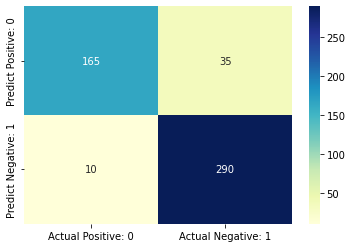

In [ ]:
cm_matrix = pd.DataFrame(data = cm, columns = ['Actual Positive: 0', 'Actual Negative: 1'], index = ['Predict Positive: 0', 'Predict Negative: 1'])
sns.heatmap(cm_matrix, annot = True, fmt = 'd', cmap = 'YlGnBu')